# 3D shape classification - Riccado Lincetto

This notebook uses the 3DShapeNets dataset to perform volumetric classification with a 3D convolutional neural network.

## Background

With the recent spreading of inexpensive 2.5D depth sensors (or RGBD sensors) it has now become crucial being able to handle volumetric shapes. To this end, 3DShapeNets (http://3dshapenets.cs.princeton.edu) proposes to represent 3D objects as probability distributions on a 3D voxel grid. Starting then from mesh data (as Object File Format (OFF) or similar formats), 3D voxel grids can be created by setting to 1 the voxels belonging to the mesh and to 0 the remaining voxels. When dealing with a 2D depth-map obtained from a RGBD sensor instead, usually there isn't enough information to completely reconstruct the scene because points in occluded space (e.g. behind the surfaces captured from the sensor) might either belong to the shape or not. This approach however enables also convertion of 2D depth-maps to 3D voxel grids by setting "uncertain" points to a value between 0 and 1, representing the probability of each voxel being part of the object.<br>
3DShapeNets provides also a dataset of Object File Format samples and some code to perform a classification task on them. The dataset contains 40 different types of objects, but there is also a restricted version with only 10 different classes. The meshes of the objects in those datasets are completely defined (i.e. voxels are only set to either 0 or 1), so simulating the use of 2.5D sensors on them requires projecting objects to 2D planes with different focal points: luckily enough, among the code provided by the authors, there are already a MATLAB function doing it ('3DShapeNets/util/write_input_data.m') and the output produced by this function (in '3DShapeNets/volumetric_data/'), which constitutes the input that the model should be fed with. In this notebook that volumetric data will be used to perform classification directly, instead of recurring to the MATLAB funtion. The model that is used in 3DShapeNets is a Convolutional Deep Belief Network, a network with 5 hidden layers achieving 83.5% accuracy on the restricted dataset ('ModelNet10') and 77% on the integral one ('ModelNet40'). The purpose of this notebook is instead to train a simpler 3D CNN.

## Notebook setup

Here is a list of parameters that can be modified to execute properly the code:
- <mark>path</mark>: string containing the location where data is stored. Once the source code has been downloaded from http://3dshapenets.cs.princeton.edu and extracted on a local folder, set 'path' to the directory containing the '3DShapeNets' subfolder. Note that it doesn't need to be inside the directory where this notebook is stored because an 'absolute' path is used, not a relative one. Note: do not include the final slash and avoid using backslashes (Windows format);
- <mark>classes</mark>: set of classes to be used for classification. Select one of the two configurations, with 10 or 40 classes respectively, or test the code on new configurations;
- <mark>use_pretrained</mark>: boolean flag to indicate whether the use of a pre-trained model is preferred over the training of a new one from the beginning. Set it to 'True' to use a pre-trained model or to 'False' to train a new model. The desired pre-trained model has to be in the subfolder "./models/", while its name has to be specified in the following variable;
- <mark>model_in_name</mark>: string representing the name of the model to be loaded, when 'use_pretrained' is set to True. The model has to be stored inside "./models/";
- <mark>training_phase</mark>: boolean flag indicating whether there should be or not a training phase. This variable is used because there can be training phases both for new models and for pre-trained ones, thanks to the versatility of Keras framework. If 'use_pretrained' is set to False, then 'training_phase' is automatically set to True because a new model is required;
- <mark>model_out_name</mark>: string representing the name of the model to be stored. After the training phase, the model is saved in "./models/" with the name here specified: this happens independently from the value of 'use_pretrained', in fact it depends only on 'training_phase' flag.

Insert block diagram

In [1]:
path = "C:/Users/Riccardo/Documents/MATLAB/3DAR"

In [2]:
# 10 classes
classes = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]

# 40 classes
#classes = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet', \
#           'airplane', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'cone', 'cup', 'curtain', 'door', \
#           'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'person', 'piano', 'plant', \
#           'radio', 'range_hood', 'sink', 'stairs', 'stool', 'tent', 'tv_stand', 'vase', 'wardrobe', 'xbox']

In [3]:
use_pretrained = False

In [4]:
model_in_name = "model.h5"

In [5]:
training_phase = True

In [6]:
model_out_name = "model_2_2_50.h5"

## Dataset

'3DShapeNets/volumetric_data/' folder contains 40 subfolders, each named with the corresponding class label. Inside these are stored training and test sets in different directories:
- Training set: ./30/train/
- Test set: ./30/test/

The number of instances inside each set is variable. All objects have shape 24 x 24 x 24 but, since 3 voxels of extra padding are already added in each dimension, they result having 30 x 30 x 30 voxels.

In [7]:
# import useful libraries
import numpy as np
import os
from random import randint
from scipy import io
from utils import load_mat, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv3D, LeakyReLU, MaxPooling3D, Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

C:\Users\Riccardo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# set data path
path = path + "/3DShapeNets/volumetric_data/"
print("Data will be loaded from", path)

Data will be loaded from C:/Users/Riccardo/Documents/MATLAB/3DAR/3DShapeNets/volumetric_data/


Data is loaded into a dictionary, where the keys are the class names and the values are variable length 4D numpy arrays, where the variable dimension is the first (representing the number of instances) and the size of each of them is [number_of_instances, 30, 30, 30].

In [9]:
n_classes = len(classes)
print("Classification on", n_classes, "classes.")

trainSet = {}
testSet = {}
train_size = np.zeros([n_classes, 1])
test_size = np.zeros([n_classes, 1])

for index, name in enumerate(classes):
    print("\nImporting class:", name)
    
    folder = path + name + "/30/train/"
    trainSet[name], train_size[index] = load_mat(folder, train=True)
    
    folder = path + name + "/30/test/"
    testSet[name], test_size[index] = load_mat(folder, train=False)
    
print("\nDone.")

Classification on 10 classes.

Importing class: bathtub
Training set: 1272
Test set    : 600

Importing class: bed
Training set: 6180
Test set    : 1200

Importing class: chair
Training set: 10668
Test set    : 1200

Importing class: desk
Training set: 2400
Test set    : 1032

Importing class: dresser
Training set: 2400
Test set    : 1032

Importing class: monitor
Training set: 5580
Test set    : 1200

Importing class: night_stand
Training set: 2400
Test set    : 1032

Importing class: sofa
Training set: 8160
Test set    : 1200

Importing class: table
Training set: 4704
Test set    : 1200

Importing class: toilet
Training set: 4128
Test set    : 1200

Done.


## Data visualization
Set manually the 'class_name' variable to one of the classes just imported. The rest of the cell selects randomly one instance of the class in the training set and displays it. Note that here all non-zero points are displayed with the same intensity.

Displaying toilet sample with index 3936


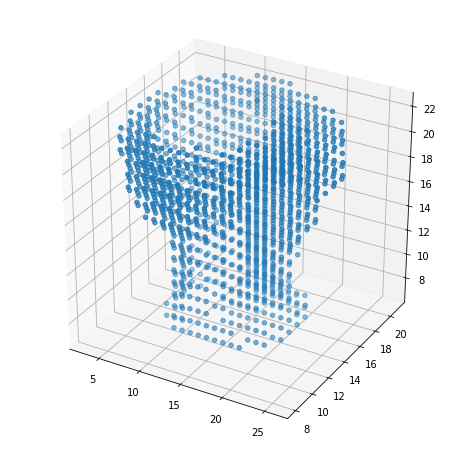

In [10]:
class_name = "toilet"

# randomly select instance
num = randint(0, trainSet[class_name].shape[0] - 1)
print("Displaying", class_name, "sample with index", num)

# plot object
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
xs, yx, zs = trainSet[class_name][num].nonzero()
ax.scatter3D(xs, yx, zs)

## Processing

Here training and test sets are created, together with their labels: dictionaries trainingSet and testSet are tranformed into 5D numpy arrays, where the first dimension is the number of samples and the last is the number of channels, needed by Keras, which in this case is one.

In [11]:
print("Training samples:", int(np.sum(train_size)))
X_train = np.zeros([int(np.sum(train_size)), 30, 30, 30, 1])
Y_train = np.zeros([int(np.sum(train_size)), 1])
train_count = 0
for index, name in enumerate(classes):
    print("Copying class", name, "into portion:", train_count, train_count+int(train_size[index]))
    X_train[train_count:train_count+int(train_size[index]), :, :, :, 0] = trainSet[name]
    Y_train[train_count:train_count+int(train_size[index])] = index
    train_count += int(train_size[index])
    
print("\nTest samples:    ", int(np.sum(test_size)))
X_test = np.zeros([int(np.sum(test_size)), 30, 30, 30, 1])
Y_test = np.zeros([int(np.sum(test_size)), 1])
test_count = 0
for index, name in enumerate(classes):
    print("Copying class", name, "into portion:", test_count, test_count+int(test_size[index]))
    X_test[test_count:test_count+int(test_size[index]), :, :, :, 0] = testSet[name]
    Y_test[test_count:test_count+int(test_size[index])] = index
    test_count += int(test_size[index])

Training samples: 47892
Copying class bathtub into portion: 0 1272
Copying class bed into portion: 1272 7452
Copying class chair into portion: 7452 18120
Copying class desk into portion: 18120 20520
Copying class dresser into portion: 20520 22920
Copying class monitor into portion: 22920 28500
Copying class night_stand into portion: 28500 30900
Copying class sofa into portion: 30900 39060
Copying class table into portion: 39060 43764
Copying class toilet into portion: 43764 47892

Test samples:     10896
Copying class bathtub into portion: 0 600
Copying class bed into portion: 600 1800
Copying class chair into portion: 1800 3000
Copying class desk into portion: 3000 4032
Copying class dresser into portion: 4032 5064
Copying class monitor into portion: 5064 6264
Copying class night_stand into portion: 6264 7296
Copying class sofa into portion: 7296 8496
Copying class table into portion: 8496 9696
Copying class toilet into portion: 9696 10896


## Model

In the following, it is possible either to build and train a model from scratch, or to load a pre-trained one. In the latter case training phase is optional and it takes place according to the value of variable 'training_phase'. To choose one of the two main options instead, set 'use_pretrained' accoringly.<br>
Here the current settings are reported.

In [12]:
print("use_pretrained:", use_pretrained)
if use_pretrained:
    print("Loading from:", "./models/" + model_in_name)
else:
    training_phase = True

print("\ntraining_phase:", training_phase)
if training_phase:
    print("Storing to :", "./models/" + model_out_name)

use_pretrained: False

training_phase: True
Storing to : ./models/model_2_2_50.h5


### Pre-trained model

In [13]:
if use_pretrained:
    
    # load model
    model = load_model("./models/" + model_in_name)
    
    # display model summary
    print("Loading model:")
    model.summary()

In [40]:
if not(use_pretrained):

    model = Sequential()
    
    model.add(Conv3D(filters=n_classes*2,
                     kernel_size=(7,7,7),
                     strides=(2,2,2),
                     use_bias=True,
                     input_shape=(30,30,30,1))) # padding avoided because already present
    model.add(LeakyReLU(alpha=0.3))
    #model.add(MaxPooling3D(pool_size=(2,2,2),
    #                       strides=(2,2,2),
    #                       padding='same'))

    model.add(Conv3D(filters=n_classes*5,
                     kernel_size=(2,2,2),
                     strides=(2,2,2),
                     use_bias=True))
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling3D(pool_size=(2,2,2),
                           strides=(2,2,2),
                           padding='same'))

    #model.add(Conv3D(filters=100,
    #                 kernel_size=(3,3,3),
    #                 strides=(1,1,1),
    #                 use_bias=True,
    #                 padding='same'))
    #model.add(LeakyReLU(alpha=0.3))
    #model.add(MaxPooling3D(pool_size=(2,2,2),
    #                       strides=(2,2,2),
    #                       padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # model visualization
    model.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 12, 12, 12, 20)    6880      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 12, 12, 12, 20)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 6, 6, 6, 50)       8050      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6, 6, 6, 50)       0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 3, 3, 3, 50)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1350)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1350)              0         
__________

### New model

In [41]:
# model visualization

if not(use_pretrained):
    
    import pydot
    from IPython.display import SVG
    from keras.utils.vis_utils import model_to_dot
    #SVG(model_to_dot(model).create(prog='dot', format='svg'))
    
    from keras.utils import plot_model
    #plot_model(model, to_file='model.png')

### Model training
If a new model is used, then it is also compiled here; otherwise only the actual training part is executed.

In [42]:
if training_phase and not(use_pretrained):
    
    opt = Adam(lr=0.001, decay=0.0001)
    
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
if training_phase:
    
    model.fit(x=X_train, y=to_categorical(Y_train),
              batch_size=128, epochs=20,
              validation_data=(X_test, to_categorical(Y_test)),
              shuffle=True)
    
    # store model
    if not(os.path.exists("./models/")):
        os.makedirs("./models/")
    model.save("./models/" + model_out_name)    

Train on 47892 samples, validate on 10896 samples
Epoch 1/20
47892/47892 [==============================] - 34s 711us/step - loss: 0.5946 - acc: 0.8102 - val_loss: 0.5536 - val_acc: 0.8312
Epoch 2/20
47892/47892 [==============================] - 32s 659us/step - loss: 0.2960 - acc: 0.9053 - val_loss: 0.4685 - val_acc: 0.8537
Epoch 3/20
47892/47892 [==============================] - 34s 703us/step - loss: 0.2362 - acc: 0.9225 - val_loss: 0.4084 - val_acc: 0.8731
Epoch 4/20
47892/47892 [==============================] - 36s 748us/step - loss: 0.2018 - acc: 0.9327 - val_loss: 0.4114 - val_acc: 0.8774
Epoch 5/20
47892/47892 [==============================] - 34s 719us/step - loss: 0.1737 - acc: 0.9408 - val_loss: 0.4048 - val_acc: 0.8823
Epoch 6/20
47892/47892 [==============================] - 32s 679us/step - loss: 0.1559 - acc: 0.9462 - val_loss: 0.3976 - val_acc: 0.8761
Epoch 7/20
47892/47892 [==============================] - 31s 652us/step - loss: 0.1469 - acc: 0.9492 - val_loss: 0.

## Results

In [44]:
Y_pred = model.predict(X_test)      # results are one hot encoded
Y_pred = np.argmax(Y_pred, axis=1)  # switch back to categorical representation

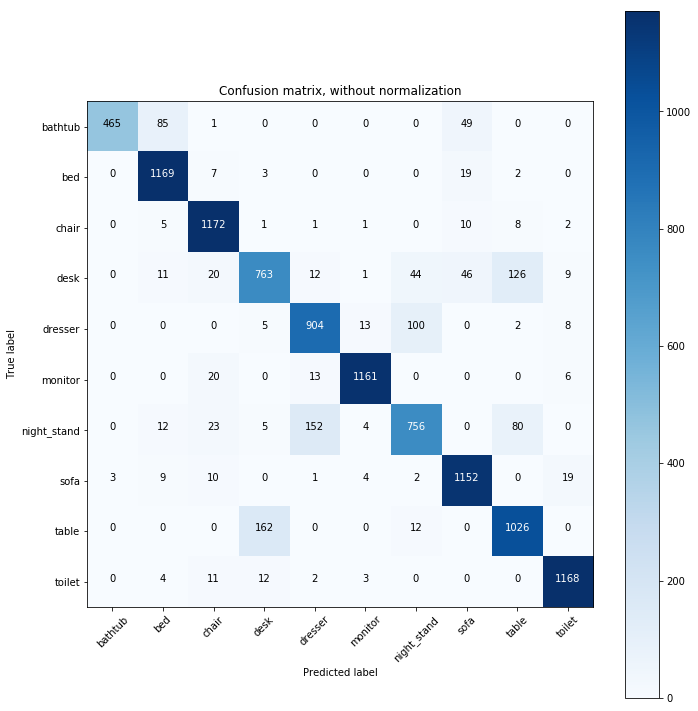

In [45]:
# Compute and plot confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)
%matplotlib inline

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

## Comments
Here the most common source of errors is inspected. Which are the classes that couse more misclassifications?

In [46]:
# set to 0 the diagonal point of the confusion matrix and find the max
for i in range(n_classes):
    cnf_matrix[i,i] = 0

true_lab = classes[np.argmax(cnf_matrix) // n_classes]
pred_lab = classes[np.argmax(cnf_matrix) % n_classes]
print("The most recurrent error is predicting", pred_lab, "when having instead a", true_lab)

The most recurrent error is predicting desk when having instead a table


Is this error justified? Are the two classes similar? Here two random instances of the involved classes are displayed.

Displaying sample of table with index 2118


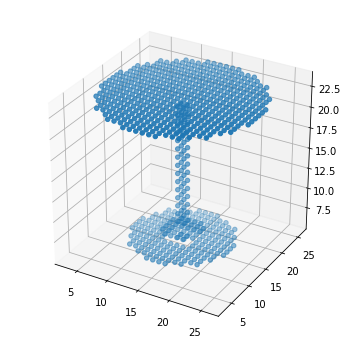

In [47]:
# randomly select instance
num_t = randint(0, trainSet[true_lab].shape[0] - 1)
num_p = randint(0, trainSet[pred_lab].shape[0] - 1)
print("Displaying sample of", true_lab, "with index", num_t)

%matplotlib inline

# true label
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
xs, yx, zs = trainSet[true_lab][num_t,:,:,:].nonzero()
ax.scatter3D(xs, yx, zs)

Displaying sample of desk with index 2266


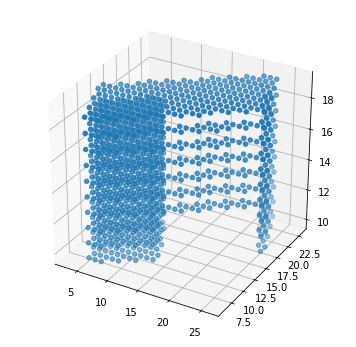

In [48]:
print("Displaying sample of", pred_lab, "with index", num_p)
# predicted label
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
xs, yx, zs = trainSet[pred_lab][num_p,:,:,:].nonzero()
ax.scatter3D(xs, yx, zs)

The most common source of errors is confusing tables with desks or night stands with dressers (and viceversa). This seems justifiable by the fact that these couples of classes usually differ by their sizes, which aren't accounted for in this dataset: objects are in fact stored within the same number of voxels with a normalized scale, thus neglecting the information on the original size of the object.